# Linear Model with TensorFlow

Let's use the MTA Subway data, combined with weather data, to predict the number of entries at the station.
In this notebook I will use TensorFlow to create a simple linear regression model.

Start with importing necessary libraries and loading data.

In [2]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
from exploratory_analysis import *

%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

turnstile, weather = load_data('Data/master_turnstile_file.txt', 'Data/weather_underground.csv')
data = merge_turnstile_weather(turnstile, weather)

data.head()

,C/A,UNIT,SCP,DATEn,TIMEn,DESCn,ENTRIESn,EXITSn,EXITSn_hourly,ENTRIESn_hourly,...,precipi,snowfalli,since1jancoolingdegreedaysnormal,precipm,snowfallm,thunder,monthtodateheatingdegreedays,meantempi,maxvism,meantempm
0,A002,R051,02-00-00,2011-05-21,00:00:00,REGULAR,3169391,1097585,0.0,0.0,...,0.1,0.0,41,1.8,0.0,0,81,67,16,19
1,A002,R051,02-00-00,2011-05-21,04:00:00,REGULAR,3169415,1097588,3.0,24.0,...,0.1,0.0,41,1.8,0.0,0,81,67,16,19
2,A002,R051,02-00-00,2011-05-21,08:00:00,REGULAR,3169431,1097607,19.0,16.0,...,0.1,0.0,41,1.8,0.0,0,81,67,16,19
3,A002,R051,02-00-00,2011-05-21,12:00:00,REGULAR,3169506,1097686,79.0,75.0,...,0.1,0.0,41,1.8,0.0,0,81,67,16,19
4,A002,R051,02-00-00,2011-05-21,16:00:00,REGULAR,3169693,1097734,48.0,187.0,...,0.1,0.0,41,1.8,0.0,0,81,67,16,19


There are some columns with only null entries, and some columns with unique value, so I will drop them.

In [3]:
data = drop_null_columns(data)
data = drop_one_value_columns(data)

data.describe()

,ENTRIESn,EXITSn,EXITSn_hourly,ENTRIESn_hourly,HOUR,maxpressurem,maxdewptm,maxpressurei,maxdewpti,since1julheatingdegreedaysnormal,...,minpressurei,monthtodatecoolingdegreedays,maxtempi,minpressurem,precipi,since1jancoolingdegreedaysnormal,precipm,monthtodateheatingdegreedays,meantempi,meantempm
count,5154.0,5154.0,5154.0,5154.0,5154.0,5154.0,5154.0,5154.0,5154.0,5154.0,...,5154.0,5154.0,5154.0,5154.0,5154.0,5154.0,5154.0,5154.0,5154.0,5154.0
mean,3923576.5,3433468.8,27356.7,41122.3,10.3,1016.3,17.9,30.0,64.3,4750.3,...,29.8,16.6,75.5,1010.2,0.0,49.7,0.7,91.4,68.2,19.9
std,3536423.7,3872260.9,473030.2,445437.2,6.8,4.3,2.5,0.1,4.3,4.5,...,0.1,12.3,8.8,4.8,0.0,5.9,1.0,4.7,6.8,3.8
min,0.0,51.0,-5249768.0,0.0,0.0,1009.0,14.0,29.8,57.0,4743.0,...,29.5,5.0,58.0,1000.0,0.0,41.0,0.0,81.0,56.0,13.0
25%,1154194.2,946166.5,40.0,51.0,4.0,1014.0,16.0,29.9,61.0,4746.0,...,29.8,5.0,67.0,1009.0,0.0,44.0,0.0,90.0,61.0,16.0
50%,3066787.5,2257733.5,149.5,183.0,12.0,1016.0,17.0,30.0,63.0,4751.0,...,29.9,14.0,78.0,1011.0,0.0,50.0,0.0,94.0,71.0,22.0
75%,5445599.8,4434324.2,403.0,450.0,16.0,1021.0,21.0,30.1,69.0,4755.0,...,29.9,30.0,83.0,1013.0,0.1,56.0,1.8,94.0,74.0,23.0
max,18935728.0,24578513.0,17560300.0,11521719.0,22.0,1023.0,21.0,30.2,70.0,4757.0,...,30.0,39.0,84.0,1017.0,0.1,59.0,2.5,94.0,75.0,24.0



Columns 'EXITSn_hourly' and 'ENTRIESn_hourly' both can be chosen as targets/features, and they have some evident outliers.


In [4]:
# Cut 2.5% of data from each end
data = cut_outliers(data, "ENTRIESn_hourly", 0.025)
data = cut_outliers(data, "EXITSn_hourly", 0.025)

data.describe()

,ENTRIESn,EXITSn,EXITSn_hourly,ENTRIESn_hourly,HOUR,maxpressurem,maxdewptm,maxpressurei,maxdewpti,since1julheatingdegreedaysnormal,...,minpressurei,monthtodatecoolingdegreedays,maxtempi,minpressurem,precipi,since1jancoolingdegreedaysnormal,precipm,monthtodateheatingdegreedays,meantempi,meantempm
count,4899.0,4899.0,4899.0,4899.0,4899.0,4899.0,4899.0,4899.0,4899.0,4899.0,...,4899.0,4899.0,4899.0,4899.0,4899.0,4899.0,4899.0,4899.0,4899.0,4899.0
mean,3857306.1,3258356.2,244.0,296.1,10.3,1016.3,17.9,30.0,64.2,4750.4,...,29.8,16.7,75.3,1010.2,0.0,49.7,0.7,91.5,68.1,19.9
std,3503278.3,3625130.7,276.7,351.9,6.8,4.4,2.5,0.1,4.4,4.5,...,0.1,12.3,8.9,4.9,0.0,5.8,1.0,4.6,6.8,3.9
min,0.0,51.0,0.0,0.0,0.0,1009.0,14.0,29.8,57.0,4743.0,...,29.5,5.0,58.0,1000.0,0.0,41.0,0.0,81.0,56.0,13.0
25%,1148618.0,937219.0,37.0,47.0,4.0,1014.0,16.0,29.9,61.0,4746.0,...,29.8,5.0,67.0,1009.0,0.0,44.0,0.0,90.0,61.0,16.0
50%,3057465.0,2221961.0,137.0,167.0,12.0,1016.0,17.0,30.0,63.0,4751.0,...,29.9,14.0,78.0,1011.0,0.0,50.0,0.0,94.0,71.0,22.0
75%,5424373.0,4218719.5,356.5,409.0,16.0,1021.0,21.0,30.1,69.0,4755.0,...,29.9,30.0,83.0,1013.0,0.1,56.0,1.8,94.0,74.0,23.0
max,18935728.0,24577071.0,1307.0,1992.0,22.0,1023.0,21.0,30.2,70.0,4757.0,...,30.0,39.0,84.0,1017.0,0.1,59.0,2.5,94.0,75.0,24.0


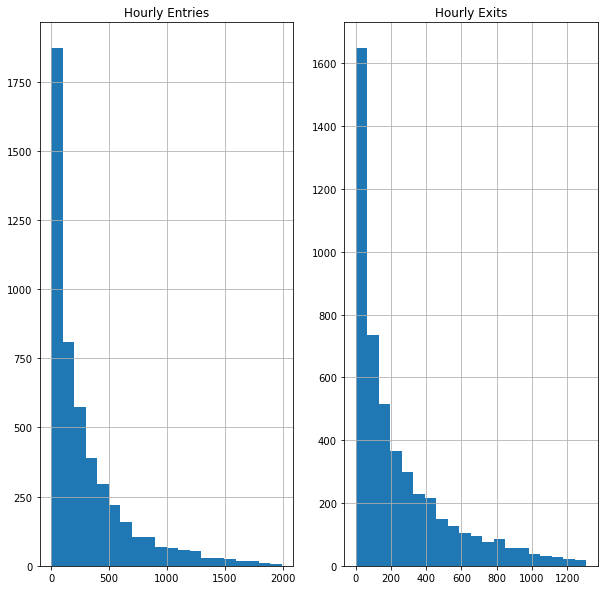

In [6]:
# Plot histograms of entries and exits number
fig, ax = plt.subplots(1, 2, figsize=(10,10))

data['ENTRIESn_hourly'].hist(ax=ax[0], bins=20)
ax[0].set_title('Hourly Entries')

data['EXITSn_hourly'].hist(ax=ax[1], bins=20)
ax[1].set_title('Hourly Exits')

What a great Poisson distributions they are!..

I would like to choose hourly number of entries 'ENTRIESn_hourly' as a target to predict.

Right now there are a lot of features in the data set, and I am not going to use them all. Let's start with looking at the correlation matrix and choose few most significant.

In [29]:
corr_m = data.corr()
corr_m["ENTRIESn_hourly"].apply(lambda x: abs(x)).sort_values(ascending=False)[:10]

ENTRIESn_hourly                      1.0
EXITSn_hourly                        0.6
coolingdegreedaysnormal              0.2
monthtodateheatingdegreedays         0.2
since1julheatingdegreedays           0.2
meanwindspdi                         0.2
since1julheatingdegreedaysnormal     0.1
monthtodateheatingdegreedaysnormal   0.1
meanwindspdm                         0.1
maxwspdi                             0.1
Name: ENTRIESn_hourly, dtype: float64

Column 'EXITSn_hourly' is highly correlated with target entries number. However, these two variables are clearly dependent in sense that if we know one of them, the other should also been known... So it is hardly will be usefull for any future predictions.

There are also some complex features as 'monthtodateheatingdegreedays' or 'since1julheatingdegreedays', so I will not use them for now.

In [30]:
def preprocess_features(data):
    """
        Prepares input features from MTA Subway/Weather Underground merged data set.
        
        Parameters:
            data: A DataFrame expected to contain preprocessed data from mta subway/weather 
            underground data set.
            
        Returns:
            A DataFrame that contains the features to be used for the model, including synthetic
            features.
    """
    selected_features = data['HOUR',
                             'DayOfWeek',
                             'coolingdegreedaysnormal',
                             'rain',
                             'fog',
                             'meanwindspdi',
                             'mintempi']
    processed_features = selected_features.copy()
    
    # Let's add one more feature: Day of Week - I think it must be significant...
    precessed_features['DOW'] = pd.to_datetime(data['DATEn']).dt.dayofweek
    
    return processed_features